# Setting arguments

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import argparse


# setting hyperparameters
parser = argparse.ArgumentParser(description='RelationNet')
parser.add_argument('--gpu', '-g', 
                    type=int, 
                    default=0,
                    help='GPU ID (-1 indicates CPU)')#Set the initial matrix
parser.add_argument('--epoch',
                    type=int, 
                    default=10,
                    help='Number of training time')
parser.add_argument('--episode',
                    type=int, 
                    default=10,
                    help='Number of test time')
parser.add_argument('--sample',
                    type=int, 
                    default=60,
                    help='Number of sample image')
# create arg object
args = parser.parse_args([])

# Loading mini-Imagenet

In [2]:
from miniImage import miniImage
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

csv_file = './mini-imagenet/train.csv'
root_dir = './mini-imagenet/train'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.92206, 0.92206, 0.92206], std=[0.08426, 0.08426, 0.08426])
])

testset = miniImage(csv_file = csv_file,
                    root_dir = root_dir,
                    transform = transform)

sample_set = torch.utils.data.DataLoader(testset,
                                         batch_size=args.sample,
                                         shuffle=True, 
                                         num_workers=6)
query_set = torch.utils.data.DataLoader(testset,
                                        batch_size=1,
                                        shuffle=True, 
                                        num_workers=0)

# Using GPU

In [3]:
if(args.gpu == -1):
    device = torch.device('cpu')
else:
    device = torch.device('cuda:'+str(args.gpu) if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
torch.cuda.empty_cache()
print(device)

cuda:0


# Build Feature Net

In [4]:
class CNNEncoder(nn.Module):
    """docstring for ClassName"""
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3,64,kernel_size=3,padding=0),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,64,kernel_size=3,padding=0),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
                        nn.Conv2d(64,64,kernel_size=3,padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU())
        self.layer4 = nn.Sequential(
                        nn.Conv2d(64,64,kernel_size=3,padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU())

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out # 64
    
encoder = CNNEncoder().to(device)
encoder.eval()
encoder.load_state_dict(torch.load('miniimagenet_feature_encoder_5way_5shot.pkl', map_location=device))

<All keys matched successfully>

# Build Relation Net

In [5]:
class RelationNetwork(nn.Module):
    """docstring for RelationNetwork"""
    def __init__(self):
        super(RelationNetwork, self).__init__()
        self.fc1 = nn.Linear(64*19*19*2, 512)
        self.pr1 = nn.PReLU()
        self.fc2 = nn.Linear(512, 64)
        self.pr2 = nn.PReLU()
        self.fc3 = nn.Linear(64, 1)

    def forward(self,x):
        out = x.view(x.size(0),-1)
        out = self.pr1(self.fc1(out))
        out = self.pr2(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        return out
    
relation_net = RelationNetwork().to(device)
relation_net.eval()
relation_net.load_state_dict(torch.load('miniimagenet_relation_net_5way_5shot.pkl', map_location=device))

<All keys matched successfully>

# Meta-Testing

tensor(63)


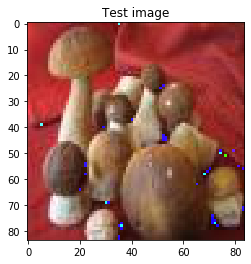

------------------ Test start ------------------
Precision = 13.043478%
Sensitivity = 2.500000%
Accuracy = 77.166667%
tensor(3)


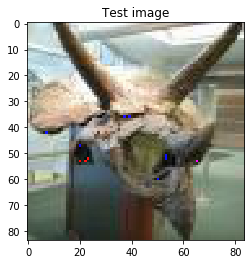

------------------ Test start ------------------
Precision = 20.000000%
Sensitivity = 1.984127%
Accuracy = 77.750000%
tensor(59)


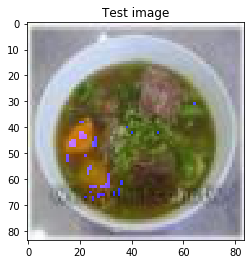

------------------ Test start ------------------
Precision = 81.987578%
Sensitivity = 32.835821%
Accuracy = 83.388889%
tensor(59)


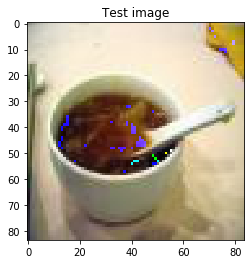

------------------ Test start ------------------
Precision = 82.222222%
Sensitivity = 33.882784%
Accuracy = 83.291667%
tensor(3)


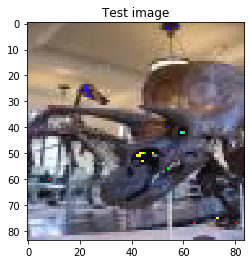

------------------ Test start ------------------
Precision = 79.741379%
Sensitivity = 27.286136%
Accuracy = 82.000000%
tensor(60)


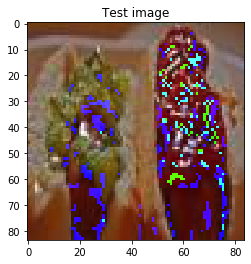

------------------ Test start ------------------
Precision = 80.053191%
Sensitivity = 37.252475%
Accuracy = 83.833333%
tensor(60)


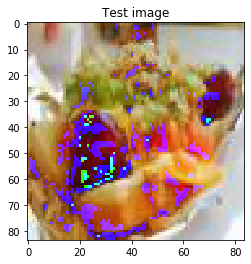

------------------ Test start ------------------
Precision = 75.045872%
Sensitivity = 43.696581%
Accuracy = 84.214286%
tensor(3)


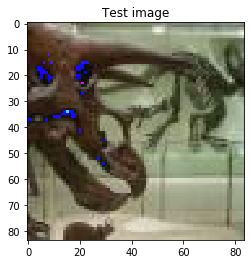

------------------ Test start ------------------
Precision = 74.908425%
Sensitivity = 38.295880%
Accuracy = 83.416667%
tensor(60)


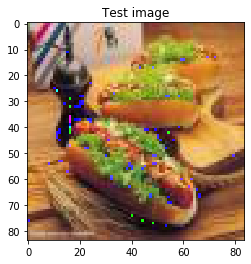

------------------ Test start ------------------
Precision = 76.377953%
Sensitivity = 40.484140%
Accuracy = 84.018519%
tensor(3)


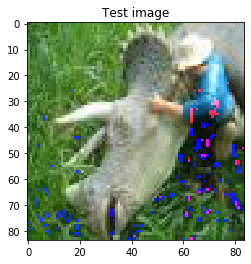

------------------ Test start ------------------
Precision = 76.175549%
Sensitivity = 36.706949%
Accuracy = 83.500000%


In [6]:
import matplotlib.pyplot as plt
transform = transforms.Compose([
    transforms.Normalize(mean=[1/0.92206, 1/0.92206, 1/0.92206], std=[1/0.08426, 1/0.08426, 1/0.08426]),
    transforms.ToPILImage()
])

TP = 0
FP = 0
FN = 0
TN = 0
"""
Episode
"""
for episode, query in zip(range(args.episode), query_set):
    query_imgs = query['data'].to(device)
    query_label = query['label']
    query_features = encoder(query_imgs)
    
    print(query_label[0])
    img = query_imgs[0].to('cpu')
    img = transform(img)
    plt.imshow(img)
    plt.title('Test image')
    plt.show()
    print('------------------ Test start ------------------')
    
    """
    Epoch
    """
    for epoch, sample in zip(range(args.epoch), sample_set):
        sample_imgs = sample['data'].to(device) # [batch x 3 x 84 x 84]
        sample_label = sample['label']
        sample_features = encoder(sample_imgs) # [batch, 64, 19, 19]

        # copy 
        copied_query = query_features.repeat(args.sample, 1, 1, 1) #[batch x 64 x 19 x 19]  
        inputs = torch.cat([sample_features, copied_query], dim=1) #[batch x 128 x 19 x 19]
        outputs = relation_net(inputs)

        for i, class_prob in enumerate(outputs):
            if(class_prob > 0.6):
#                 print(sample_label[i])
#                 img = sample_imgs[i].to('cpu')
#                 img = transform(img)
#                 plt.imshow(img)
#                 plt.title('Similar image')
#                 plt.show() 
                
                if(sample_label[i] == query_label[0]):
                    TP += 1
                else:
                    FP += 1
            else:
                if(sample_label[i] == query_label[0]):
                    FN += 1
                else:
                    TN += 1
    
    print('Precision = {:5%}'.format(TP/(TP+FP) if (TP+FP)!=0 else 0))
    print('Sensitivity = {:5%}'.format(TP/(TP+FN) if (TP+FN)!=0 else 0))
    print('Accuracy = {:5%}'.format((TP+TN)/(TP+FP+FN+TN)))